# **_Sentiment Analysis_**

### Here is everything you are going to need to run this notebook

* nltk.download('all')
* pip install pyenchant 
---

There some files that have the results of the cleaning ready.If you want to use them leave the below variable as is.

In [2]:
use_files=1


The first thing that we are going to do is load all the files that we need.

The twitters datasets first.

In [3]:
import pandas as pd

dataset_gold = pd.read_csv("../twitter_data/SemEval2017_task4_subtaskA_test_english_gold.txt", encoding='utf8',delimiter='\t',header=None);
dataset_train = pd.read_csv("../twitter_data/train2017.tsv", encoding='utf8',delimiter='\t',header=None);
dataset_test = pd.read_csv("../twitter_data/test2017.tsv", encoding='utf8',delimiter='\t',header=None);


And now the lexicons

In [4]:
from read_files import read_lexica
all_lex=[] #list of dictionaries
all_lex.append(read_lexica("../lexica/affin/affin.txt"))
all_lex.append(read_lexica("../lexica/emotweet/valence_tweet.txt"))
all_lex.append(read_lexica("../lexica/generic/generic.txt"))
all_lex.append(read_lexica("../lexica/nrc/val.txt"))
all_lex.append(read_lexica("../lexica/nrctag/val.txt"))
all_lex.append(read_lexica("../lexica/sentric/senticnet5.txt"))


Some libraries that we are going to need below are here

In [18]:
from nltk.corpus import stopwords
nltk_stopwords = set(stopwords.words('english'))  

from nltk.tokenize import TweetTokenizer
tknzr = TweetTokenizer(strip_handles=True, reduce_len=True)

from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()

from read_files import read_dict
from fix_tweets import clean_tw

import enchant
d = enchant.Dict("en_US")

import pickle

from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score,f1_score

import numpy as np
import matplotlib.pyplot as plt
import random

from PIL import Image
from os import path ,getcwd
from wordcloud import WordCloud
from colour_wc import random_color_func


This is were the cleaning is.If you want to skip this part and use the files set the use_flies variable to 1.

In [6]:
y2 = dataset_train.iloc[:, 2]
y3 = dataset_train.iloc[:, 3]
train_data=list(map(list, zip(y2,y3))) #list of tweets and values

fixed_tweets,hash_tags,name_tags=clean_tw(train_data)

words=read_dict()
import csv        
if use_files==0:
    for tweet in fixed_tweets:
        tw=tweet[0]
        tw=tknzr.tokenize(tw)
        tw1=[]
        for word in tw:
            word=word.lower()
            tw1.append(stemmer.stem(word))

        tweet[0] = " ".join(tw1)
    
    with open('resources/twitter_fixed.tsv', 'w', newline='') as f_output:
        tsv_output = csv.writer(f_output, delimiter='\t')
        for tweet in fixed_tweets:
            tsv_output.writerow([tweet[0]])


### Bag of words


In [7]:
dataset_fix_train = pd.read_csv('resources/twitter_fixed.tsv', encoding='utf8',delimiter='\t',header=None);

corpus=[]
for i in range(dataset_fix_train.shape[0]):
    tweet = dataset_fix_train.iloc[i, 0]
    corpus.append(str(tweet))

test_tweets=[]   
for i in range(dataset_test.shape[0]):
    tweet = dataset_test.iloc[i, 3]
    test_tweets.append(tweet) 

from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(stop_words=nltk_stopwords ,max_features=1000)


X = vectorizer.fit_transform(corpus).toarray()
y = dataset_train.iloc[:, 2]

classifier = GaussianNB()
classifier.fit(X, y)

with open('bof_uni.pkl', 'wb') as handle:
    pickle.dump(classifier, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('bof_uni.pkl', 'rb') as handle:
    classifier = pickle.load(handle)
    
X_test= vectorizer.fit_transform(test_tweets).toarray()
y_pred = classifier.predict(X_test)
y_test=dataset_gold.iloc[:, 1]



This are the results of bag of words

In [7]:
print("classification_report")
print(classification_report(y_test, y_pred))
print("______________________________________________________")

print("accuracy_score normalized")
print(accuracy_score(y_test, y_pred))
print("_________________________")
print("accuracy_score" )
print(accuracy_score(y_test, y_pred, normalize=False))
print("_________________________")

print(f1_score(y_test, y_pred,average=None))
print(f1_score(y_test, y_pred,average='macro'))
print(f1_score(y_test, y_pred,average='micro'))
print(f1_score(y_test, y_pred,average='weighted'))

classification_report
              precision    recall  f1-score   support

    negative       0.31      0.33      0.32      3972
     neutral       0.50      0.41      0.45      5937
    positive       0.19      0.26      0.22      2375

    accuracy                           0.35     12284
   macro avg       0.33      0.33      0.33     12284
weighted avg       0.38      0.35      0.36     12284

______________________________________________________
accuracy_score normalized
0.3549332464995116
_________________________
accuracy_score
4360
_________________________
[0.32040841 0.44986098 0.2215817 ]
0.33061703023706274
0.3549332464995115
0.3638670948068934


For the bag of words above we used unigrams to get those results.In sentiment analysis this is not the best approach.We will now use bigrams and see how our results change.

In [8]:
vectorizer_bigram = CountVectorizer(stop_words=nltk_stopwords ,max_features=1000,ngram_range=(2, 2))
X = vectorizer_bigram.fit_transform(corpus).toarray()
classifier = GaussianNB()
classifier.fit(X, y)

with open('bof_bi.pkl', 'wb') as handle:
    pickle.dump(classifier, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('bof_bi.pkl', 'rb') as handle:
    classifier = pickle.load(handle)

X_test= vectorizer_bigram.fit_transform(test_tweets).toarray()
y_pred = classifier.predict(X_test)

The results this time

In [9]:
print("classification_report")
print(classification_report(y_test, y_pred))
print("______________________________________________________")

print("accuracy_score normalized")
print(accuracy_score(y_test, y_pred))
print("_________________________")
print("accuracy_score" )
print(accuracy_score(y_test, y_pred, normalize=False))
print("_________________________")

print("F1_score with average [None,macro,micro,weighted]")
print(f1_score(y_test, y_pred,average=None))
print(f1_score(y_test, y_pred,average='macro'))
print(f1_score(y_test, y_pred,average='micro'))
print(f1_score(y_test, y_pred,average='weighted'))

classification_report
              precision    recall  f1-score   support

    negative       0.32      0.71      0.44      3972
     neutral       0.49      0.15      0.23      5937
    positive       0.19      0.13      0.15      2375

    accuracy                           0.33     12284
   macro avg       0.33      0.33      0.27     12284
weighted avg       0.38      0.33      0.28     12284

______________________________________________________
accuracy_score normalized
0.3266037121458808
_________________________
accuracy_score
4012
_________________________
F1_score with average [None,macro,micro,weighted]
[0.43766062 0.23270764 0.15041783]
0.27359536085153835
0.3266037121458808
0.28306867113879036


This time the results seem to be worse.This is not what we expected.This might be because we didnt have enought tweets to train under sets of words.

We will try one last time with trigrams so we can catch cases like "not very good"

In [10]:
vectorizer_trigram = CountVectorizer(stop_words=nltk_stopwords ,max_features=1000,ngram_range=(3, 3))
X = vectorizer_trigram.fit_transform(corpus).toarray()
classifier = GaussianNB()
classifier.fit(X, y)

with open('bof_tri.pkl', 'wb') as handle:
    pickle.dump(classifier, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('bof_tri.pkl', 'rb') as handle:
    classifier = pickle.load(handle)

X_test= vectorizer_trigram.fit_transform(test_tweets).toarray()
y_pred = classifier.predict(X_test)

The results for trigrams

In [11]:
print("classification_report")
print(classification_report(y_test, y_pred))
print("______________________________________________________")

print("accuracy_score normalized")
print(accuracy_score(y_test, y_pred))
print("_________________________")
print("accuracy_score" )
print(accuracy_score(y_test, y_pred, normalize=False))
print("_________________________")

print("F1_score with average [None,macro,micro,weighted]")
print(f1_score(y_test, y_pred,average=None))
print(f1_score(y_test, y_pred,average='macro'))
print(f1_score(y_test, y_pred,average='micro'))
print(f1_score(y_test, y_pred,average='weighted'))

classification_report
              precision    recall  f1-score   support

    negative       0.33      0.87      0.47      3972
     neutral       0.53      0.07      0.13      5937
    positive       0.18      0.07      0.10      2375

    accuracy                           0.33     12284
   macro avg       0.35      0.34      0.23     12284
weighted avg       0.40      0.33      0.23     12284

______________________________________________________
accuracy_score normalized
0.3282318463041355
_________________________
accuracy_score
4032
_________________________
F1_score with average [None,macro,micro,weighted]
[0.47338416 0.12615019 0.09844084]
0.2326583992381063
0.3282318463041355
0.2330700575484521


This is better than bigram but still worse than unigram

### Tf-Idf 

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words=nltk_stopwords, strip_accents="ascii", lowercase=True,max_features=1000)

X = vectorizer.fit_transform(corpus).toarray()
y = dataset_train.iloc[:, 2]

classifier = GaussianNB()
classifier.fit(X, y)

X_test= vectorizer.fit_transform(test_tweets).toarray()
y_pred = classifier.predict(X_test)
y_test=dataset_gold.iloc[:, 1]




Results of Tf-idf

In [13]:
print("classification_report")
print(classification_report(y_test, y_pred))
print("______________________________________________________")

print("accuracy_score normalized")
print(accuracy_score(y_test, y_pred))
print("_________________________")
print("accuracy_score" )
print(accuracy_score(y_test, y_pred, normalize=False))
print("_________________________")

print(f1_score(y_test, y_pred,average=None))
print(f1_score(y_test, y_pred,average='macro'))
print(f1_score(y_test, y_pred,average='micro'))
print(f1_score(y_test, y_pred,average='weighted'))

classification_report
              precision    recall  f1-score   support

    negative       0.31      0.29      0.30      3972
     neutral       0.50      0.44      0.47      5937
    positive       0.21      0.30      0.25      2375

    accuracy                           0.36     12284
   macro avg       0.34      0.34      0.34     12284
weighted avg       0.38      0.36      0.37     12284

______________________________________________________
accuracy_score normalized
0.3623412569195702
_________________________
accuracy_score
4451
_________________________
[0.30115931 0.46608947 0.24504567]
0.3374314797150824
0.3623412569195702
0.3700229065852436


Again we will try to usr bigrams to see the difference

In [14]:
vectorizer = TfidfVectorizer(stop_words=nltk_stopwords, strip_accents="ascii", lowercase=True,max_features=1000,ngram_range=(2, 2))

X = vectorizer.fit_transform(corpus).toarray()
y = dataset_train.iloc[:, 2]

classifier = GaussianNB()
classifier.fit(X, y)

X_test= vectorizer.fit_transform(test_tweets).toarray()
y_pred = classifier.predict(X_test)
y_test=dataset_gold.iloc[:, 1]

Results

In [15]:
print("classification_report")
print(classification_report(y_test, y_pred))
print("______________________________________________________")

print("accuracy_score normalized")
print(accuracy_score(y_test, y_pred))
print("_________________________")
print("accuracy_score" )
print(accuracy_score(y_test, y_pred, normalize=False))
print("_________________________")

print(f1_score(y_test, y_pred,average=None))
print(f1_score(y_test, y_pred,average='macro'))
print(f1_score(y_test, y_pred,average='micro'))
print(f1_score(y_test, y_pred,average='weighted'))

classification_report
              precision    recall  f1-score   support

    negative       0.33      0.73      0.45      3972
     neutral       0.50      0.16      0.25      5937
    positive       0.20      0.12      0.15      2375

    accuracy                           0.34     12284
   macro avg       0.34      0.34      0.28     12284
weighted avg       0.39      0.34      0.29     12284

______________________________________________________
accuracy_score normalized
0.33922175187235426
_________________________
accuracy_score
4167
_________________________
[0.45092879 0.24850869 0.1459273 ]
0.28178826274596347
0.33922175187235426
0.29412753352450194


Trigrams

In [16]:
vectorizer = TfidfVectorizer(stop_words=nltk_stopwords, strip_accents="ascii", lowercase=True,max_features=1000,ngram_range=(3, 3))

X = vectorizer.fit_transform(corpus).toarray()
y = dataset_train.iloc[:, 2]

classifier = GaussianNB()
classifier.fit(X, y)

X_test= vectorizer.fit_transform(test_tweets).toarray()
y_pred = classifier.predict(X_test)
y_test=dataset_gold.iloc[:, 1]

Results

In [17]:
print("classification_report")
print(classification_report(y_test, y_pred))
print("______________________________________________________")

print("accuracy_score normalized")
print(accuracy_score(y_test, y_pred))
print("_________________________")
print("accuracy_score" )
print(accuracy_score(y_test, y_pred, normalize=False))
print("_________________________")

print(f1_score(y_test, y_pred,average=None))
print(f1_score(y_test, y_pred,average='macro'))
print(f1_score(y_test, y_pred,average='micro'))
print(f1_score(y_test, y_pred,average='weighted'))

classification_report
              precision    recall  f1-score   support

    negative       0.33      0.86      0.47      3972
     neutral       0.53      0.08      0.14      5937
    positive       0.18      0.07      0.10      2375

    accuracy                           0.33     12284
   macro avg       0.34      0.34      0.24     12284
weighted avg       0.40      0.33      0.24     12284

______________________________________________________
accuracy_score normalized
0.3295343536307392
_________________________
accuracy_score
4048
_________________________
[0.47288803 0.13593658 0.09881061]
0.23587840826035655
0.3295343536307392
0.23771100199429693


### Word Embeddings

In [ ]:
from Word2Vec import WordEmbeddingsVectorize

WordEmbeddingsVectorize(fixed_tweets,size=100,pkl_filename="resources/word_embed_pickle.pkl")

### Data Analysis

First we need to load the test file to a list 

In [8]:
y2=dataset_gold.iloc[:, 1]
y3 = dataset_test.iloc[:, 3]
test_data=list(map(list, zip(y2,y3))) 
  
fixed_tweets,hash_tags,name_tags=clean_tw(train_data)
fixed_tweets1,hash_tags1,name_tags1=clean_tw(test_data)

fixed_tweets+=fixed_tweets1
hash_tags+=hash_tags1
name_tags+=name_tags1
all_data=train_data+test_data


Most used words in tweets

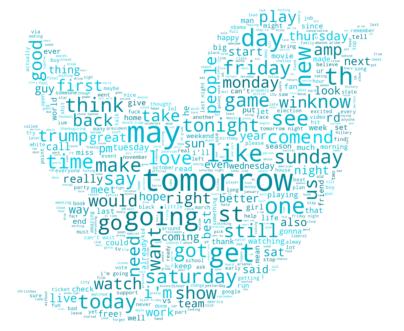

In [9]:
wd_text=""

for tweet_info in fixed_tweets:
    tweet_info[0]=tknzr.tokenize(tweet_info[0].lower())
    wd_text+=" ".join(tweet_info[0])

d = path.dirname(__file__) if "__file__" in locals() else getcwd()
mask = np.array(Image.open(path.join(d, "twitter_mask.png")))

nltk_WC = WordCloud(background_color="white",max_words=500, mask=mask, stopwords=nltk_stopwords, margin=10,
               random_state=1).generate(wd_text)

plt.figure(figsize=[7,7])
plt.imshow(nltk_WC.recolor(color_func=random_color_func, random_state=3),
           interpolation="bilinear")
plt.axis("off")
plt.show()
nltk_WC.to_file("twitter_general_WC.png")

Most used words in positive tweets

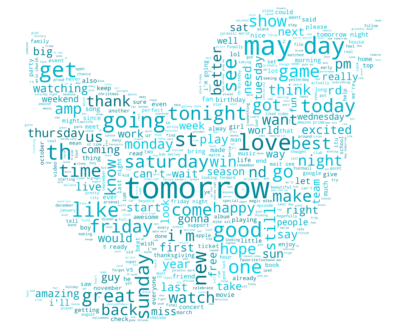

In [10]:
wd_text=""

for i in range(len(fixed_tweets)):
    if all_data[i][0]=="positive":       
        wd_text+=" ".join(fixed_tweets[i][0])

mask = np.array(Image.open(path.join(d, "twitter_mask.png")))

nltk_WC = WordCloud(background_color="white",max_words=500, mask=mask, stopwords=nltk_stopwords, margin=10,
               random_state=1).generate(wd_text)

plt.figure(figsize=[7,7])
plt.imshow(nltk_WC.recolor(color_func=random_color_func, random_state=3),
           interpolation="bilinear")
plt.axis("off")
plt.show()
nltk_WC.to_file("twitter_positive_WC.png")

Most used words in negative tweets

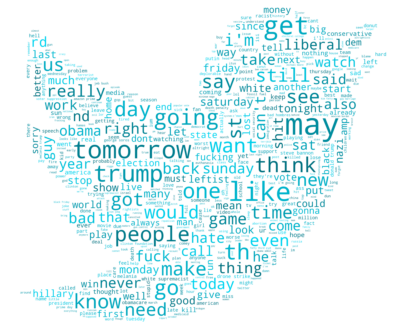

In [11]:
wd_text=""

for i in range(len(fixed_tweets)):
    if all_data[i][0]=="negative":       
        wd_text+=" ".join(fixed_tweets[i][0])

mask = np.array(Image.open(path.join(d, "twitter_mask.png")))

nltk_WC = WordCloud(background_color="white",max_words=500, mask=mask, stopwords=nltk_stopwords, margin=10,
               random_state=1).generate(wd_text)

plt.figure(figsize=[7,7])
plt.imshow(nltk_WC.recolor(color_func=random_color_func, random_state=3),
           interpolation="bilinear")
plt.axis("off")
plt.show()
nltk_WC.to_file("twitter_negative_WC.png")

Most used words in neutral tweets

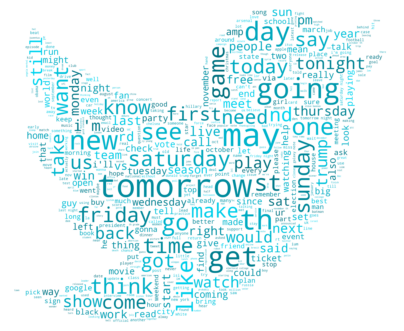

In [12]:
wd_text=""

for i in range(len(fixed_tweets)):
    if all_data[i][0]=="neutral":       
        wd_text+=" ".join(fixed_tweets[i][0])

mask = np.array(Image.open(path.join(d, "twitter_mask.png")))

nltk_WC = WordCloud(background_color="white",max_words=500, mask=mask, stopwords=nltk_stopwords, margin=10,
               random_state=1).generate(wd_text)

plt.figure(figsize=[7,7])
plt.imshow(nltk_WC.recolor(color_func=random_color_func, random_state=3),
           interpolation="bilinear")
plt.axis("off")
plt.show()
nltk_WC.to_file("twitter_neutral_WC.png")

Most used tags

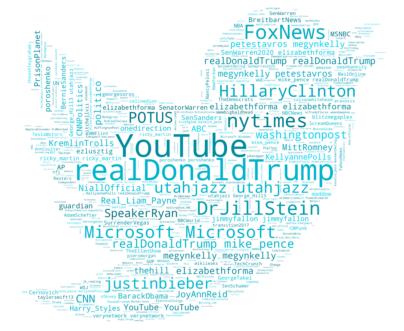

In [13]:

wd_text=""
wd_text=" ".join(name_tags)

mask = np.array(Image.open(path.join(d, "twitter_mask.png")))

nltk_WC = WordCloud(background_color="white",max_words=500, mask=mask, stopwords=nltk_stopwords, margin=10,
               random_state=1).generate(wd_text)

plt.figure(figsize=[7,7])
plt.imshow(nltk_WC.recolor(color_func=random_color_func, random_state=3),
           interpolation="bilinear")
plt.axis("off")
plt.show()
nltk_WC.to_file("twitter_tags_WC.png")

Most used hash tags

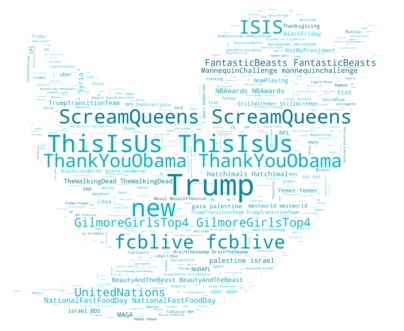

In [14]:
wd_text=""
wd_text=" ".join(hash_tags)
mask = np.array(Image.open(path.join(d, "twitter_mask.png")))

nltk_WC = WordCloud(background_color="white",max_words=500, mask=mask, stopwords=nltk_stopwords, margin=10,
               random_state=1).generate(wd_text)

plt.figure(figsize=[7,7])
plt.imshow(nltk_WC.recolor(color_func=random_color_func, random_state=3),
           interpolation="bilinear")
plt.axis("off")
plt.show()
nltk_WC.to_file("twitter_hash_WC.png")

#### General info

In [15]:
all_tweets_num=len(fixed_tweets)
all_tweets_name_tagg=0
all_tweets_hash_tagg=0
all_tweets_link=0

for tweet in fixed_tweets:
    if len(tweet[1])!=0:
        all_tweets_hash_tagg+=1
    if len(tweet[2])!=0:
        all_tweets_name_tagg+=1   
    if len(tweet[3])!=0:
        all_tweets_link+=1   

        
print("Out of the " +str(all_tweets_num)+" tweets "+str(all_tweets_hash_tagg)
      +" used hash tags "+str(all_tweets_name_tagg)+
      " tagged someone and "+str(all_tweets_name_tagg)+" used links");

Out of the 40242 tweets 9568 used hash tags 12931 tagged someone and 12931 used links


Below we try to find mistakes in tweets.This is not very accurate around (60% accuracy)

In [19]:
mistakes=0
for tweet in fixed_tweets:
    tw=tweet[0]
    for word in tw:
        wd=word.lower()
        if not d.check(wd):
            if wd not in words:
                mistakes+=1
                break
print("Out of the " +str(all_tweets_num)+" tweets "+str(mistakes)+ " had mistakes")


Out of the 40242 tweets 29259 had mistakes
